# Visualizing experimental elastic cross sections compared to Koning-Delaroche predictions

In [1]:
import pickle
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from periodictable import elements
import pickle

In [2]:
import elm

Using database version x4i3_X4-2023-04-29 located in: /home/kyle/mambaforge/envs/om/lib/python3.10/site-packages/x4i3/data


In [3]:
import exfor_tools
import jitr

In [4]:
# plotting
kd_color = "#bc5090"
qelm_color = "#f28d3d"
elm_color = "#4277c0"

In [5]:
proton = (1, 1)
neutron = (1, 0)

In [6]:
import json

param_file = jitr.data_dir /  "KD_default.json"
kduq_omp_neutron = jitr.reactions.kduq.KDGlobal(neutron, param_file)
kduq_omp_proton = jitr.reactions.kduq.KDGlobal(proton, param_file)

In [7]:
with open("../workspaces/corpus_elastic.pkl", "rb") as f:
    workspaces = pickle.load(f)

## decide target and projectile

In [91]:
target = (90,40)
A,Z = target
projectile = proton
#projectile = neutron

In [92]:
target_ws = workspaces[projectile][target]
omp = kduq_omp_neutron if projectile == neutron else kduq_omp_proton

In [93]:
len(target_ws)

19

 ## run calculation and plot

In [94]:
n_per_plt = 8
n_plts = len(target_ws) // n_per_plt
n_plts = [n_per_plt] * n_plts
rem = len(target_ws) % n_per_plt
if rem > 0:
    n_plts.append(rem)
n_plts

[8, 8, 3]

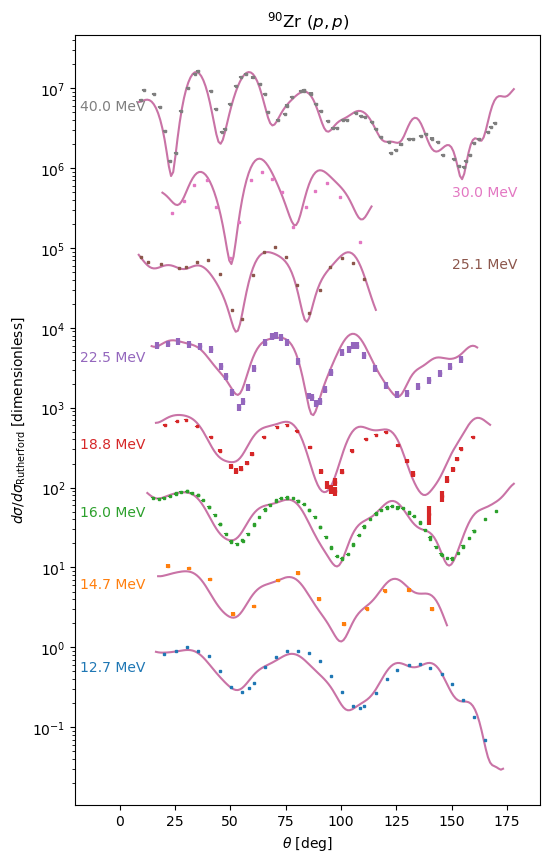

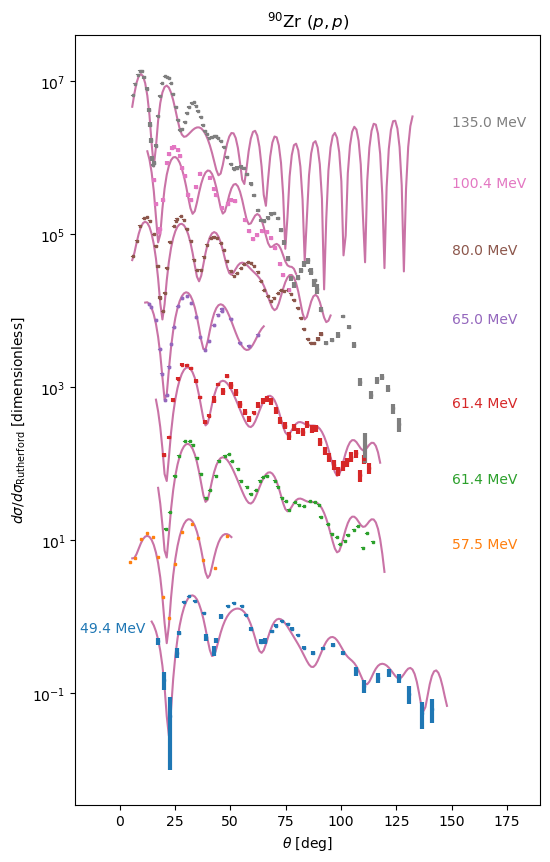

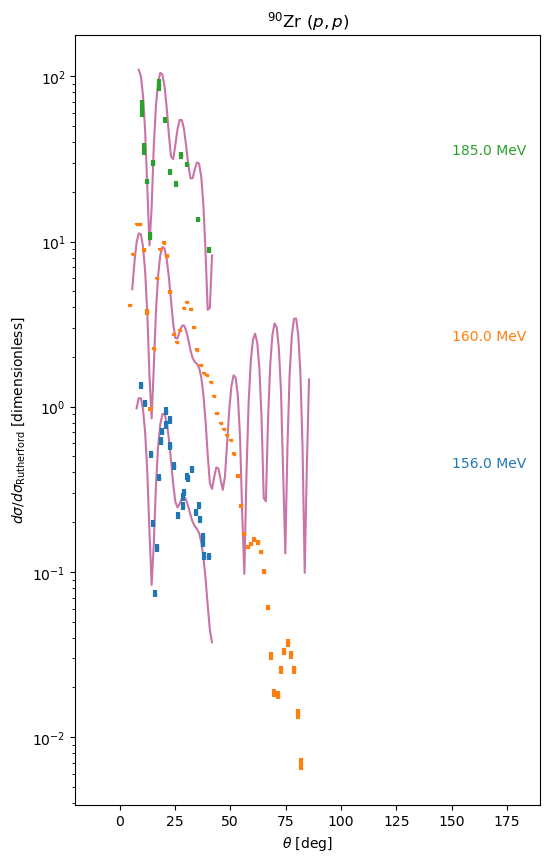

In [95]:
idx = 0
for n in n_plts:
    fig, ax = plt.subplots(figsize=(6, 10))
    
    for i in range(n):
        offset = 10 ** (i)
        ws = target_ws[idx + i]
        #offset = 1
        coulomb_params, central_params, spin_orbit_params = omp.get_params(
            *ws.calibration_model.target,
            ws.calibration_model.mu,
            ws.exp.Elab,
            ws.calibration_model.k,
        )
        xs_sample = ws.visualization_model.xs(
            jitr.reactions.kduq.KD_central_plus_coulomb,
            jitr.reactions.kduq.KD_spin_orbit,
            (central_params, coulomb_params),
            spin_orbit_params,
        )
        x, dx, y, dy = ws.exp.data
        
        xth = ws.angles_vis * 180 / np.pi
        if projectile == proton:
            yth = xs_sample.dsdo  / ws.visualization_model.rutherford
        else:
            yth = xs_sample.dsdo
        mask = np.logical_and(xth >= x[0]*0.8, xth <= x[-1] * 1.05 )
        
        plt.plot( xth[mask], yth[mask] * offset, color=kd_color, alpha=0.8)

        p = plt.errorbar(
            x,
            y * offset ,
            yerr=dy *offset,
            linestyle="none",
            elinewidth=3,
            marker="s",
            markersize=2,
         #   color='k'
        )
    
        
        if x[0] > 15 and x[-1] > 170:
            xloc = -18
            yloc = np.mean(y) 
        elif x[-1] < 140:
            xloc = 150
            yloc = np.mean(y) 
        else:
            xloc = -18
            yloc = np.mean(y) 

            
        plt.text( xloc, yloc*offset, f"{ws.exp.Elab:.1f} MeV", color=p.lines[0].get_color())
    idx += n
    plt.yscale("log")
    plt.xlabel(r"$\theta$ [deg]")
    if projectile == proton:
        plt.ylabel(r"$d\sigma/d\sigma_\text{Rutherford}$ [dimensionless]")
    else:
        plt.ylabel(r"$\d\sigma/d\Omega$ [mb/Sr]")
    #plt.ylim([10, 1e6])
    A,Z = target
    rxn = r"$(p,p)$" if projectile == proton else r"$(n,n)$"
    plt.title(f"$^{{{A}}}${elements[Z]} {rxn}")
    plt.xlim([-20,190])